In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

import sys
sys.path.append('../src/')

from cnn.models import ConvNet
from cnn.preprocessing import LabelEncoder

def read_data(path, **kwargs):
    from scipy.interpolate import interp1d
    data = pd.read_csv(path, **kwargs)
    x, y = data[0], data[1]
    # Obtain interpolation function (input original x (time) and y (signal))
    f = interp1d(x, y)
    # Create new x (same x_min and x_max but different number of data points)
    x_new = np.linspace(x.min(), x.max(), 8192)
    # Obtain new y (based on new x)
    y_new = f(x_new)
    # return both new x and new y
    return x_new, y_new

In [44]:
NUM_TRAIN_EXAMPLES = int(1e6)
NUM_TEST_EXAMPLES = int(1e4)

NUM_CLASSES = 3
NUM_WINDOWS = 256
INPUT_SIZE = 8192

# Define label encoder to decode predictions later on
label_encoder = LabelEncoder(NUM_WINDOWS)

# Build model (should have the same parameters as the model
# in 01_cnn-train.ipynb)
model = ConvNet(
    filters=[64, 128, 128, 256, 256],
    kernel_sizes=[9, 9, 9, 9, 9],
    dropout=0.0,
    pool_type='max',
    pool_sizes=[2, 2, 2, 2, 2],
    conv_block_size=1,
    input_shape=(INPUT_SIZE, 1),
    output_shape=(NUM_WINDOWS, NUM_CLASSES),
    residual=False
)

# Load pretrained weights
# If retrained (via 01_train-cnn.ipynb), weights should be loaded as 
# outputs/weights/weight_{epoch:03d}.h5 (e.g. outputs/weights/weight_009.h5)
model.load_weights('output/weights/cnn_weights.h5')

In [45]:
# Read data (applies linear interpolation to get the right dimension)
# t = time; s = signal
t, s = read_data('../input/examples/chromatogram_1.CSV', header=None, sep='\t', encoding='utf-16')

In [49]:
# Normalize and add batch dimension (model expect batched data)
s_norm = s[None, :, None] / s.max()

# Pass to model and make predictions
preds = model(s_norm)[0]

# .decode will filter out predictions below threshold
# and compute the appropriate locations of the peaks
probs, locs, areas = label_encoder.decode(preds, threshold=0.5)

print("Predicted locations:\n", locs * t.max())
print("\nPredicted areas:\n", areas)
print("\nPredicted probabilities:\n", probs)

Predicted locations:
 [0.25499871 0.2787459  0.31594139 0.3212241  0.37778986 0.3927709
 0.41192103 0.43154964 0.46724594 0.50458951 0.52206382 0.54353085
 0.56839723 0.64630365 0.79994613 0.89354416 0.97692937 1.05183473
 1.2110013  1.31395777 1.40063196 1.41185101 1.42373263 1.43203806
 1.71510601 1.78527723 1.90239507 2.04436856 2.08055641 2.15302714
 2.36198878 2.37267149 2.38444773]

Predicted areas:
 [2.3643615  1.9743078  1.6542337  0.93557364 2.3993707  1.0255017
 1.0523462  1.1597594  0.534905   1.1432674  0.77861404 1.1399598
 1.1073015  0.7343933  1.1372161  0.58276486 0.8129743  0.9889248
 1.2940395  1.0011461  1.4526376  2.4184458  2.3967469  2.068837
 0.7072395  2.5395641  1.1507461  1.5725256  1.3370751  0.8464321
 1.4568404  1.4704967  1.306283  ]

Predicted probabilities:
 [0.9999995  0.99999416 0.72051793 0.9666222  0.99992955 0.999902
 0.99976534 0.99986863 0.9987207  0.60016745 0.99965    0.99978095
 0.999741   0.99969685 0.9999093  0.9994486  0.9997594  0.9997092
 

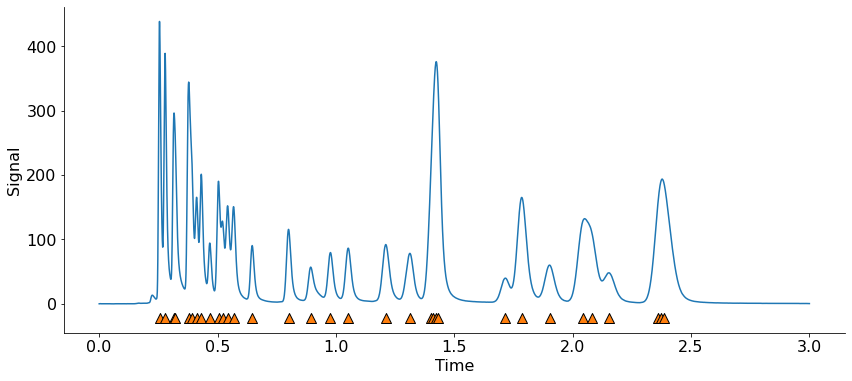

In [50]:
# Visualize locations in the chromatogram
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(t, s)

for (prob, loc, area) in zip(probs, locs, areas):
    y = s.min() - s.max() * 0.05 # location of the triangles
    ax.scatter(loc*t.max(), y, color='C1', marker='^', s=100, edgecolors='black')
    
ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel('Signal', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim(0.0, 3.0)